In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [191]:
df = pd.read_csv('../ufcScraper/ufc_fights_3yrs_from_7_8_23.csv')

## Initial Transformation (Row per Fight Perspective)

In [8]:
def create_fighter_id_map(df):
    fighters = pd.concat([df["fighter1"], df["fighter2"]]).unique()
    fighter_id_map = {name: idx for idx, name in enumerate(fighters)}
    return fighter_id_map

In [19]:
def expand_fight_row(row, fighter_id_map):
    fight_id = row.name  # use index as unique fight_id
    
    # Shared contextual fields
    base_fields = {
        "fight_id": fight_id,
        "date": row["date"],
        "event": row["event"],
        "location": row["location"],
        "method_of_victory": row["method_of_victory"],
        "fight_duration": row["fight_duration"],
        "fight_format": row["fight_format"]
    }

    # Fighter 1 perspective
    row_f1 = {
        **base_fields,
        "fighter_id": fighter_id_map[row["fighter1"]],
        "opp_id": fighter_id_map[row["fighter2"]],
        "fighter_knockdown": row["f1_knockdown"],
        "fighter_sig_strike_land": row["f1_sig_strike_land"],
        "fighter_sig_strike_att": row["f1_sig_strike_att"],
        "fighter_total_strike_land": row["f1_total_strike_land"],
        "fighter_total_strike_att": row["f1_total_strike_att"],
        "fighter_takedown_land": row["f1_takedown_land"],
        "fighter_takedown_att": row["f1_takedown_att"],
        "fighter_sub_att": row["f1_sub_att"],
        "fighter_reversal": row["f1_reversal"],
        "fighter_control_time": row["f1_control_time"],
        
        "opp_knockdown": row["f2_knockdown"],
        "opp_sig_strike_land": row["f2_sig_strike_land"],
        "opp_sig_strike_att": row["f2_sig_strike_att"],
        "opp_total_strike_land": row["f2_total_strike_land"],
        "opp_total_strike_att": row["f2_total_strike_att"],
        "opp_takedown_land": row["f2_takedown_land"],
        "opp_takedown_att": row["f2_takedown_att"],
        "opp_sub_att": row["f2_sub_att"],
        "opp_reversal": row["f2_reversal"],
        "opp_control_time": row["f2_control_time"],

        # store result from perspective of fighter1
        "fighter_win": 1 if row["result"] == 1 else 0
    }

    # Fighter 2 perspective (mirrored)
    row_f2 = {
        **base_fields,
        "fighter_id": fighter_id_map[row["fighter2"]],
        "opp_id": fighter_id_map[row["fighter1"]],
        "fighter_knockdown": row["f2_knockdown"],
        "fighter_sig_strike_land": row["f2_sig_strike_land"],
        "fighter_sig_strike_att": row["f2_sig_strike_att"],
        "fighter_total_strike_land": row["f2_total_strike_land"],
        "fighter_total_strike_att": row["f2_total_strike_att"],
        "fighter_takedown_land": row["f2_takedown_land"],
        "fighter_takedown_att": row["f2_takedown_att"],
        "fighter_sub_att": row["f2_sub_att"],
        "fighter_reversal": row["f2_reversal"],
        "fighter_control_time": row["f2_control_time"],
        
        "opp_knockdown": row["f1_knockdown"],
        "opp_sig_strike_land": row["f1_sig_strike_land"],
        "opp_sig_strike_att": row["f1_sig_strike_att"],
        "opp_total_strike_land": row["f1_total_strike_land"],
        "opp_total_strike_att": row["f1_total_strike_att"],
        "opp_takedown_land": row["f1_takedown_land"],
        "opp_takedown_att": row["f1_takedown_att"],
        "opp_sub_att": row["f1_sub_att"],
        "opp_reversal": row["f1_reversal"],
        "opp_control_time": row["f1_control_time"],

        # store result from perspective of fighter2
        "fighter_win": 1 if row["result"] == 0 else 0
    }

    return [row_f1, row_f2]


In [20]:
def build_fighter_centric_df(df):
    fighter_id_map = create_fighter_id_map(df)
    
    new_rows = []
    for _, row in df.iterrows():
        new_rows.extend(expand_fight_row(row, fighter_id_map))
    
    fighter_df = pd.DataFrame(new_rows)
    
    return fighter_df, fighter_id_map

In [55]:
fighter_df, fighter_id_map = build_fighter_centric_df(df)


In [56]:
fighter_df.columns

Index(['fight_id', 'date', 'event', 'location', 'method_of_victory',
       'fight_duration', 'fight_format', 'fighter_id', 'opp_id',
       'fighter_knockdown', 'fighter_sig_strike_land',
       'fighter_sig_strike_att', 'fighter_total_strike_land',
       'fighter_total_strike_att', 'fighter_takedown_land',
       'fighter_takedown_att', 'fighter_sub_att', 'fighter_reversal',
       'fighter_control_time', 'opp_knockdown', 'opp_sig_strike_land',
       'opp_sig_strike_att', 'opp_total_strike_land', 'opp_total_strike_att',
       'opp_takedown_land', 'opp_takedown_att', 'opp_sub_att', 'opp_reversal',
       'opp_control_time', 'fighter_win'],
      dtype='object')

In [57]:
fighter_df.method_of_victory.value_counts()

method_of_victory
Decision - Unanimous       1578
KO/TKO                     1312
Submission                  732
Decision - Split            400
Decision - Majority          62
TKO - Doctor's Stoppage      28
Overturned                   26
Could Not Continue           26
DQ                           12
Name: count, dtype: int64

## Compute Rolling Stats

In [64]:
import pandas as pd
import numpy as np

def parse_control_time(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return x
    s = str(x).strip()
    if ":" in s:
        parts = s.split(":")
        if len(parts) == 2:
            try:
                m = int(parts[0])
                sec = int(parts[1])
                return m * 60 + sec
            except:
                return np.nan
    try:
        return float(s)
    except:
        return np.nan

def normalize_method(method):
    if method in ["KO/TKO", "TKO - Doctor's Stoppage", "Could Not Continue", "DQ"]:
        return "KO"
    if method in ["Submission"]:
        return "SUB"
    if method in ["Decision - Unanimous", "Decision - Split", "Decision - Majority"]:
        return "DEC"
    return np.nan  # Overturned, NC, etc.

def add_rolling_stats(df: pd.DataFrame, window=5):
    # Make a copy to avoid mutating caller's df unexpectedly
    df = df.copy()

    # 1) Dates -> datetime
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # 2) Numeric columns: coerce to numeric
    numeric_cols = [
        "fighter_sig_strike_land", "fighter_sig_strike_att",
        "fighter_total_strike_land", "fighter_total_strike_att",
        "fighter_takedown_land", "fighter_takedown_att",
        "fighter_sub_att", "fighter_reversal",
        "opp_sig_strike_land", "opp_sig_strike_att",
        "opp_total_strike_land", "opp_total_strike_att",
        "opp_takedown_land", "opp_takedown_att",
        "opp_sub_att", "opp_reversal",
        # include any other numeric-like columns you expect
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 3) Control time -> seconds numeric
    if "fighter_control_time" in df.columns:
        df["fighter_control_time"] = df["fighter_control_time"].apply(parse_control_time)

    # Ensure chronological order per fighter
    df = df.sort_values(["fighter_id", "date"]).copy()

    # Helper ratios (safe division)
    df["sig_str_acc"] = df["fighter_sig_strike_land"] / df["fighter_sig_strike_att"].replace(0, np.nan)
    df["td_acc"] = df["fighter_takedown_land"] / df["fighter_takedown_att"].replace(0, np.nan)

    # Flags
    df["win"] = df["fighter_win"].astype(float)
    df["method"] = df["method_of_victory"].apply(normalize_method)
    df["ko_win"] = ((df["method"].isin(["KO", "TKO"])) & (df["win"] == 1)).astype(int)
    df["sub_win"] = ((df["method"] == "SUB") & (df["win"] == 1)).astype(int)
    df["dec_win"] = ((df["method"] == "DEC") & (df["win"] == 1)).astype(int)

    grp = df.groupby("fighter_id")

    # Rolling win / finish / accuracy / control (exclude current fight via shift)
    df["rolling_win_rate"] = grp["win"].apply(lambda s: s.shift().rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)
    df["rolling_ko_rate"] = grp["ko_win"].apply(lambda s: s.shift().rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)
    df["rolling_sub_rate"] = grp["sub_win"].apply(lambda s: s.shift().rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)
    df["rolling_dec_rate"] = grp["dec_win"].apply(lambda s: s.shift().rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)

    df["rolling_sig_str_acc"] = grp["sig_str_acc"].apply(lambda s: s.shift().rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)
    df["rolling_td_acc"] = grp["td_acc"].apply(lambda s: s.shift().rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)
    df["rolling_control"] = grp["fighter_control_time"].apply(lambda s: s.shift().rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)

    # Days since last fight (use diff + dt.days)
    df["days_since_last"] = grp["date"].apply(lambda x: x.diff().dt.days).reset_index(level=0, drop=True)

    return df

In [ ]:
rolling_stats_df = add_rolling_stats(fighter_df)

In [100]:
rolling_stats_df.shape

(4176, 45)

In [102]:
def add_opponent_rolling_stats(df):
    opp_cols = [
        "rolling_win_rate", "rolling_ko_rate", "rolling_sub_rate",
        "rolling_dec_rate", "rolling_sig_str_acc", "rolling_td_acc",
        "rolling_control", "days_since_last"
    ]

    # include fight_id so we match the opponent from the same fight
    opp_df = df[["fighter_id", "fight_id"] + opp_cols].copy()
    opp_df = opp_df.rename(columns={col: f"opp_{col}" for col in opp_cols})

    # merge on the opponent's fighter_id AND the fight_id (one-to-one per fight)
    df = df.merge(
        opp_df,
        how="left",
        left_on=["opp_id", "fight_id"],
        right_on=["fighter_id", "fight_id"],
        suffixes=("", "_y")
    )

    # drop the duplicate join column from right side
    if "fighter_id_y" in df.columns:
        df = df.drop(columns=["fighter_id_y"])

    return df

In [103]:
full_rolling_stats_df = add_opponent_rolling_stats(rolling_stats_df)

In [104]:
full_rolling_stats_df.shape

(4176, 53)

## Interaction Features and Ratios

In [105]:
def add_interaction_features(df):

    # DIFFERENCES (fighter minus opponent)
    df["diff_rolling_win_rate"] = df["rolling_win_rate"] - df["opp_rolling_win_rate"]
    df["diff_ko_rate"]          = df["rolling_ko_rate"] - df["opp_rolling_ko_rate"]
    df["diff_sub_rate"]         = df["rolling_sub_rate"] - df["opp_rolling_sub_rate"]
    df["diff_dec_rate"]         = df["rolling_dec_rate"] - df["opp_rolling_dec_rate"]

    df["diff_sig_str_acc"]      = df["rolling_sig_str_acc"] - df["opp_rolling_sig_str_acc"]
    df["diff_td_acc"]           = df["rolling_td_acc"] - df["opp_rolling_td_acc"]
    df["diff_control"]          = df["rolling_control"] - df["opp_rolling_control"]

    df["diff_days_last"]        = df["days_since_last"] - df["opp_days_since_last"]

    # RATIOS (fighter / opponent, clipped to avoid inf)
    for col in ["rolling_ko_rate", "rolling_sub_rate", "rolling_dec_rate",
                "rolling_sig_str_acc", "rolling_td_acc", "rolling_control"]:
        df[f"ratio_{col}"] = df[col] / (df[f"opp_{col}"] + 1e-6)

    # STRENGTH × WEAKNESS INTERACTION
    df["ko_pressure"] = df["rolling_ko_rate"] * (1 - df["opp_rolling_ko_rate"])
    df["sub_pressure"] = df["rolling_sub_rate"] * (1 - df["opp_rolling_sub_rate"])

    return df


In [106]:
interaction_stats = add_interaction_features(full_rolling_stats_df)

In [110]:
interaction_stats.columns

Index(['fight_id', 'date', 'event', 'location', 'method_of_victory',
       'fight_duration', 'fight_format', 'fighter_id', 'opp_id',
       'fighter_knockdown', 'fighter_sig_strike_land',
       'fighter_sig_strike_att', 'fighter_total_strike_land',
       'fighter_total_strike_att', 'fighter_takedown_land',
       'fighter_takedown_att', 'fighter_sub_att', 'fighter_reversal',
       'fighter_control_time', 'opp_knockdown', 'opp_sig_strike_land',
       'opp_sig_strike_att', 'opp_total_strike_land', 'opp_total_strike_att',
       'opp_takedown_land', 'opp_takedown_att', 'opp_sub_att', 'opp_reversal',
       'opp_control_time', 'fighter_win', 'sig_str_acc', 'td_acc', 'win',
       'method', 'ko_win', 'sub_win', 'dec_win', 'rolling_win_rate',
       'rolling_ko_rate', 'rolling_sub_rate', 'rolling_dec_rate',
       'rolling_sig_str_acc', 'rolling_td_acc', 'rolling_control',
       'days_since_last', 'opp_rolling_win_rate', 'opp_rolling_ko_rate',
       'opp_rolling_sub_rate', 'opp_rollin

# Model Training

In [112]:
def encode_target(row):
    if row["fighter_win"] == 1:
        if row["method"] == "KO":
            return 0
        if row["method"] == "SUB":
            return 1
        if row["method"] == "DEC":
            return 2
    else:
        if row["method"] == "KO":
            return 3
        if row["method"] == "SUB":
            return 4
        if row["method"] == "DEC":
            return 5

interaction_stats["target"] = interaction_stats.apply(encode_target, axis=1)


In [141]:
import pandas as pd
import numpy as np

df = interaction_stats.copy()
df = df.sort_values("date").copy()

# Drop leaking columns
leak_cols = [
    "fighter_win", "win", "ko_win", "sub_win", "dec_win",
    "method", "method_of_victory", "fight_duration",
    "fight_id", "event", "location", "fight_format",
    "fighter_id", "opp_id", "date"
]

drop_cols = [c for c in leak_cols if c in df.columns]

df_model = df.drop(columns=drop_cols)
df_model = df_model[df_model["target"].notna()].copy()


In [143]:
df_model.shape

(4150, 55)

#### Only Run below if categorical vars still exist

In [121]:
# cat_cols = df_model.select_dtypes(include=["object"]).columns
# print(cat_cols)

# from sklearn.preprocessing import LabelEncoder

# for c in cat_cols:
#     le = LabelEncoder()
#     df_model[c] = le.fit_transform(df_model[c].astype(str))

In [149]:
y = df_model["target"]
X = df_model.drop(columns=["target"]) if "target" in df_model.columns else df_model

In [151]:
df["date"] = pd.to_datetime(df["date"])  # ensure date is datetime

train_mask = df["date"] < "2022-01-01"
val_mask   = (df["date"] >= "2022-01-01") & (df["date"] < "2023-01-01")
test_mask  = df["date"] >= "2023-01-01"

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

C:\Users\ay3xqa\AppData\Local\Temp\ipykernel_23560\767344148.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train, y_train = X[train_mask], y[train_mask]
C:\Users\ay3xqa\AppData\Local\Temp\ipykernel_23560\767344148.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val,   y_val   = X[val_mask],   y[val_mask]
C:\Users\ay3xqa\AppData\Local\Temp\ipykernel_23560\767344148.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test,  y_test  = X[test_mask],  y[test_mask]


In [153]:
import xgboost as xgb

train_d = xgb.DMatrix(X_train, label=y_train)
val_d   = xgb.DMatrix(X_val, label=y_val)
test_d  = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softprob",
    "num_class": 6,                # KO, SUB, DEC for fighter/opponent
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "eval_metric": "mlogloss",
    "tree_method": "hist"
}

model = xgb.train(
    params,
    train_d,
    num_boost_round=800,
    evals=[(train_d, "train"), (val_d, "val")],
    early_stopping_rounds=40,
    verbose_eval=50
)


[0]	train-mlogloss:1.68273	val-mlogloss:1.71564


[50]	train-mlogloss:0.39798	val-mlogloss:0.80918
[100]	train-mlogloss:0.18910	val-mlogloss:0.71088
[150]	train-mlogloss:0.10845	val-mlogloss:0.70368
[164]	train-mlogloss:0.09432	val-mlogloss:0.70668


In [154]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

probs = model.predict(test_d)
preds = probs.argmax(axis=1)

print("Test Accuracy:", accuracy_score(y_test, preds))
print("Test LogLoss:", log_loss(y_test, probs))
print(confusion_matrix(y_test, preds))

Test Accuracy: 0.7427122940430925
Test LogLoss: 0.6507553854046813
[[193  14  26  11   2   6]
 [  2 109  21   4   2   5]
 [ 18   6 290   3   2  75]
 [ 14   5   9 185  11  28]
 [  2   1   7   3 109  21]
 [  1   2  80  20   5 286]]


In [168]:
# !pip install seaborn

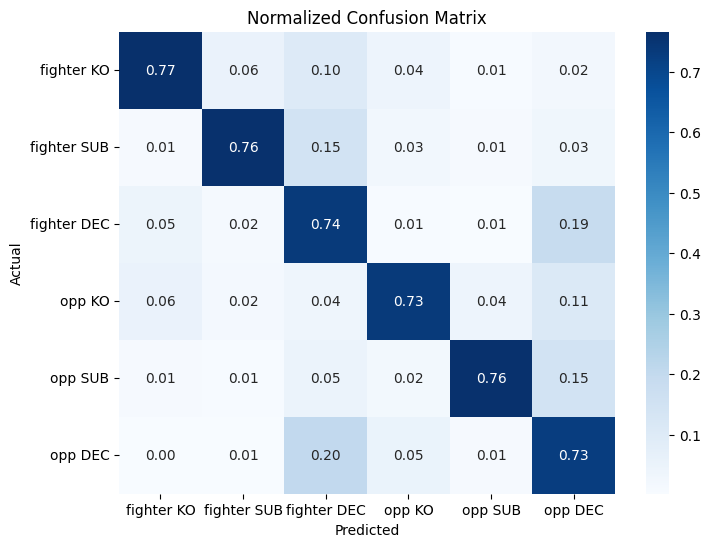

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix normalized
cm = confusion_matrix(y_test, preds, normalize='true')
class_names = ["fighter KO", "fighter SUB", "fighter DEC",
               "opp KO", "opp SUB", "opp DEC"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [155]:
# import sys
# !{sys.executable} -m pip install --upgrade pip setuptools wheel
# !{sys.executable} -m pip install xgboost

In [ ]:
import numpy as np

# Global checks (before splitting)
print("y dtype:", y.dtype)  
print("y nulls:", y.isna().sum())
print("y infs:", np.isinf(y).sum())
print("unique labels:", np.unique(y.dropna()))
print("min/max:", (y.min(), y.max()))

# After you create splits, check each set
for name, yy in [("train", y_train), ("val", y_val), ("test", y_test)]:
    print(name, "shape:", yy.shape, "nulls:", yy.isna().sum(), "infs:", np.isinf(yy).sum(),
          "unique:", np.unique(yy.dropna())[:20])

y dtype: float64
y nulls: 26
y infs: 0
unique labels: [0. 1. 2. 3. 4. 5.]
min/max: (0.0, 5.0)
train shape: (1566,) nulls: 14 infs: 0 unique: [0. 1. 2. 3. 4. 5.]
val shape: (1022,) nulls: 2 infs: 0 unique: [0. 1. 2. 3. 4. 5.]
test shape: (1588,) nulls: 10 infs: 0 unique: [0. 1. 2. 3. 4. 5.]


In [176]:
probs_pct = probs[8] * 100

# Optionally, round for readability
probs_pct = np.round(probs_pct, 2)

for cls, pct in zip(class_names, probs_pct):
    print(f"{cls}: {pct:.2f}%")

fighter KO: 3.03%
fighter SUB: 0.11%
fighter DEC: 95.78%
opp KO: 0.17%
opp SUB: 0.09%
opp DEC: 0.82%


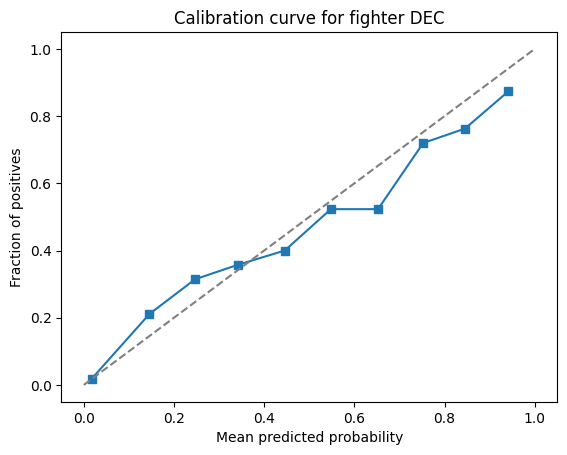

In [178]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_DEC = probs[:, class_names.index('fighter DEC')]
y_DEC = (y_test == class_names.index('fighter DEC')).astype(int)

fraction_of_positives, mean_predicted_value = calibration_curve(y_DEC, prob_DEC, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0,1],[0,1],"--", color="gray")  # perfect calibration line
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve for fighter DEC")
plt.show()

In [179]:
pred_classes = np.array([class_names[p] for p in preds])
pd.Series(pred_classes).value_counts(normalize=True)

fighter DEC    0.274398
opp DEC        0.266793
fighter KO     0.145754
opp KO         0.143219
fighter SUB    0.086819
opp SUB        0.083016
Name: proportion, dtype: float64

## Probability Adjustments for Bookmaker Odds

## Pipeline For Model Inference and Usage

In [295]:
import pandas as pd
import numpy as np

def get_rolling_mean(df, fighter_id, cols, n=3):
    """
    Compute rolling mean of the last N fights for selected columns.
    Falls back to mean of all fights if insufficient history.
    """
    fighter_df = df[df['fighter_id'] == fighter_id].sort_values('date')
    if fighter_df.empty:
        raise ValueError(f"No fights found for fighter_id: {fighter_id}")
    subset = fighter_df.tail(n) if len(fighter_df) >= n else fighter_df
    return subset[cols].mean()


def safe_ratio(numerator, denominator, default=1.0, max_val=5.0):
    """
    Compute numerator/denominator safely:
    - if denominator <= 0 or NaN, return default
    - clip result to max_val
    """
    if denominator <= 0 or np.isnan(denominator):
        ratio = default
    else:
        ratio = numerator / denominator
    return min(ratio, max_val)


def build_x_row(df, feature_cols, fighter_id, opp_id, n_avg=3):
    """
    Build a feature row for a new fight using historical data.
    - raw fight stats are averaged over last N fights
    - rolling stats are averaged over last N fights including most recent
    - interactions & pressures computed safely
    """
    # 1️⃣ Columns to average for raw fight stats
    raw_cols = [
        'fighter_knockdown', 'fighter_sig_strike_land', 'fighter_sig_strike_att',
        'fighter_total_strike_land', 'fighter_total_strike_att',
        'fighter_takedown_land', 'fighter_takedown_att',
        'fighter_sub_att', 'fighter_reversal', 'fighter_control_time'
    ]

    # 2️⃣ Columns for rolling stats
    rolling_cols = [
        'rolling_win_rate', 'rolling_ko_rate', 'rolling_sub_rate', 'rolling_dec_rate',
        'rolling_sig_str_acc', 'rolling_td_acc', 'rolling_control', 'days_since_last'
    ]

    # 3️⃣ Compute rolling averages
    f_avg_raw = get_rolling_mean(df, fighter_id, raw_cols, n_avg)
    o_avg_raw = get_rolling_mean(df, opp_id, raw_cols, n_avg)

    f_avg_roll = get_rolling_mean(df, fighter_id, rolling_cols, n_avg)
    o_avg_roll = get_rolling_mean(df, opp_id, rolling_cols, n_avg)

    # 4️⃣ Build base row dictionary
    base_row = {}

    # Fighter raw stats
    for col in raw_cols:
        base_row[col] = f_avg_raw[col]

    # Opponent raw stats
    for col in raw_cols:
        base_row[col.replace('fighter_', 'opp_')] = o_avg_raw[col]

    # Fighter rolling stats
    for col in rolling_cols:
        base_row[col] = f_avg_roll[col]

    # Opponent rolling stats
    for col in rolling_cols:
        base_row[f"opp_{col}"] = o_avg_roll[col]

    # 5️⃣ Interaction features (diffs & ratios)
    interaction_feats = ["sig_str_acc", "ko_rate", "sub_rate", "td_acc", "control", "win_rate", "dec_rate"]
    for feat in interaction_feats:
        diff_col = f"diff_{feat}"
        ratio_col = f"ratio_rolling_{feat}"

        fighter_val = f_avg_roll.get(f"rolling_{feat}", 0)
        opp_val = o_avg_roll.get(f"rolling_{feat}", 0)

        if diff_col in feature_cols:
            base_row[diff_col] = fighter_val - opp_val
        if ratio_col in feature_cols:
            base_row[ratio_col] = safe_ratio(fighter_val, opp_val)

    # 6️⃣ Pressure features
    if "ko_pressure" in feature_cols:
        base_row["ko_pressure"] = base_row.get("diff_ko_rate", 0) * base_row.get("ratio_rolling_ko_rate", 0)
    if "sub_pressure" in feature_cols:
        base_row["sub_pressure"] = base_row.get("diff_sub_rate", 0) * base_row.get("ratio_rolling_sub_rate", 0)

    # 7️⃣ Final DataFrame aligned to model columns
    x_row = pd.DataFrame([base_row])
    missing = set(feature_cols) - set(x_row.columns)
    for c in missing:
        x_row[c] = 0.0

    x_row = x_row.reindex(columns=feature_cols, fill_value=0.0)

    return x_row


In [313]:
new_row = build_x_row(interaction_stats, X.columns, fighter_id=189, opp_id=395)
new_row_mirror = build_x_row(interaction_stats, X.columns, fighter_id=395, opp_id=189)

In [314]:
new_row.columns

Index(['fighter_knockdown', 'fighter_sig_strike_land',
       'fighter_sig_strike_att', 'fighter_total_strike_land',
       'fighter_total_strike_att', 'fighter_takedown_land',
       'fighter_takedown_att', 'fighter_sub_att', 'fighter_reversal',
       'fighter_control_time', 'opp_knockdown', 'opp_sig_strike_land',
       'opp_sig_strike_att', 'opp_total_strike_land', 'opp_total_strike_att',
       'opp_takedown_land', 'opp_takedown_att', 'opp_sub_att', 'opp_reversal',
       'opp_control_time', 'sig_str_acc', 'td_acc', 'rolling_win_rate',
       'rolling_ko_rate', 'rolling_sub_rate', 'rolling_dec_rate',
       'rolling_sig_str_acc', 'rolling_td_acc', 'rolling_control',
       'days_since_last', 'opp_rolling_win_rate', 'opp_rolling_ko_rate',
       'opp_rolling_sub_rate', 'opp_rolling_dec_rate',
       'opp_rolling_sig_str_acc', 'opp_rolling_td_acc', 'opp_rolling_control',
       'opp_days_since_last', 'diff_rolling_win_rate', 'diff_ko_rate',
       'diff_sub_rate', 'diff_dec_rate', '

In [315]:
d_new = xgb.DMatrix(new_row)
d_mirror = xgb.DMatrix(new_row_mirror)
new_probs = model.predict(d_new)
mirror_probs = model.predict(d_mirror)

In [316]:
class_map = {
    0: "fighter_KO",
    1: "fighter_SUB",
    2: "fighter_DEC",
    3: "opp_KO",
    4: "opp_SUB",
    5: "opp_DEC",
}
import pandas as pd

prob_df = pd.DataFrame(
    new_probs,
    columns=[class_map[i] for i in range(new_probs.shape[1])]
)

prob_df = prob_df.T.rename(columns={0: "model_prob"})

prob_mirror_df = pd.DataFrame(
    mirror_probs,
    columns=[class_map[i] for i in range(mirror_probs.shape[1])]
)

prob_mirror_df = prob_mirror_df.T.rename(columns={0: "model_prob"})


In [317]:
prob_df, prob_mirror_df

(             model_prob
 fighter_KO     0.356574
 fighter_SUB    0.011010
 fighter_DEC    0.044779
 opp_KO         0.284717
 opp_SUB        0.012892
 opp_DEC        0.290028,
              model_prob
 fighter_KO     0.097707
 fighter_SUB    0.007640
 fighter_DEC    0.054730
 opp_KO         0.796426
 opp_SUB        0.006444
 opp_DEC        0.037053)

In [318]:
import pandas as pd
import numpy as np

# -------------------------------
# 1️⃣ Average mirrored probabilities (aligned to same fighter)
# -------------------------------
def average_mirrored_probs(probs_normal: pd.DataFrame, probs_mirrored: pd.DataFrame):
    """
    probs_normal: model output for fighter_id first
    probs_mirrored: model output for swapped fighter/opponent
    Returns averaged probabilities from the perspective of the same fighter
    """
    swap_map = {
        'fighter_KO': 'opp_KO',
        'fighter_SUB': 'opp_SUB',
        'fighter_DEC': 'opp_DEC',
        'opp_KO': 'fighter_KO',
        'opp_SUB': 'fighter_SUB',
        'opp_DEC': 'fighter_DEC'
    }
    
    # Align mirrored keys
    probs_mirrored_aligned = probs_mirrored.rename(index=swap_map)
    
    # Average
    avg_probs = (probs_normal['model_prob'] + probs_mirrored_aligned['model_prob']) / 2.0
    
    # Normalize to sum to 1
    avg_probs /= avg_probs.sum()
    
    return pd.DataFrame({'model_prob': avg_probs})


# -------------------------------
# 2️⃣ Convert American odds to implied probability
# -------------------------------
def american_to_prob(odds):
    """
    Convert American odds to implied probability
    """
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return -odds / (-odds + 100)


# -------------------------------
# 3️⃣ Compute expected value (EV)
# -------------------------------
def compute_edge(avg_probs: pd.DataFrame, american_odds: dict):
    """
    avg_probs: DataFrame with model probabilities (index = outcomes)
    american_odds: dict mapping outcomes to American odds
    Returns: DataFrame with model_prob, implied_prob, edge
    """
    edges = {}
    for outcome, odds in american_odds.items():
        model_prob = avg_probs.loc[outcome, 'model_prob']
        implied_prob = american_to_prob(odds)
        edge = model_prob - implied_prob
        edges[outcome] = {
            'model_prob': model_prob,
            'implied_prob': implied_prob,
            'edge': edge
        }
    return pd.DataFrame(edges).T




In [319]:
avg_probs = average_mirrored_probs(prob_df, prob_mirror_df)

# Example American odds from bookmaker
book_odds = {
    'fighter_KO': +250,
    'fighter_SUB': +600,
    'fighter_DEC': -200,
    'opp_KO': -150,
    'opp_SUB': +700,
    'opp_DEC': +400
}

# Compute edge
edges_df = compute_edge(avg_probs, book_odds)
print(edges_df)

             model_prob  implied_prob      edge
fighter_KO     0.576500      0.285714  0.290786
fighter_SUB    0.008727      0.142857 -0.134130
fighter_DEC    0.040916      0.666667 -0.625751
opp_KO         0.191212      0.600000 -0.408788
opp_SUB        0.010266      0.125000 -0.114734
opp_DEC        0.172379      0.200000 -0.027621
